In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
from data_utils import *
from eda_utils import *
from train_utils import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
import pickle
import os

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

## Dataset creation

In [102]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

In [103]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

## Fluorprobe outliers exploration

In [104]:
fp_df['depth_discrete'] = fp_df['depth'].apply(lambda x: min(biomass_by_week_year_group['Depth'], key=lambda y: abs(y - x)))

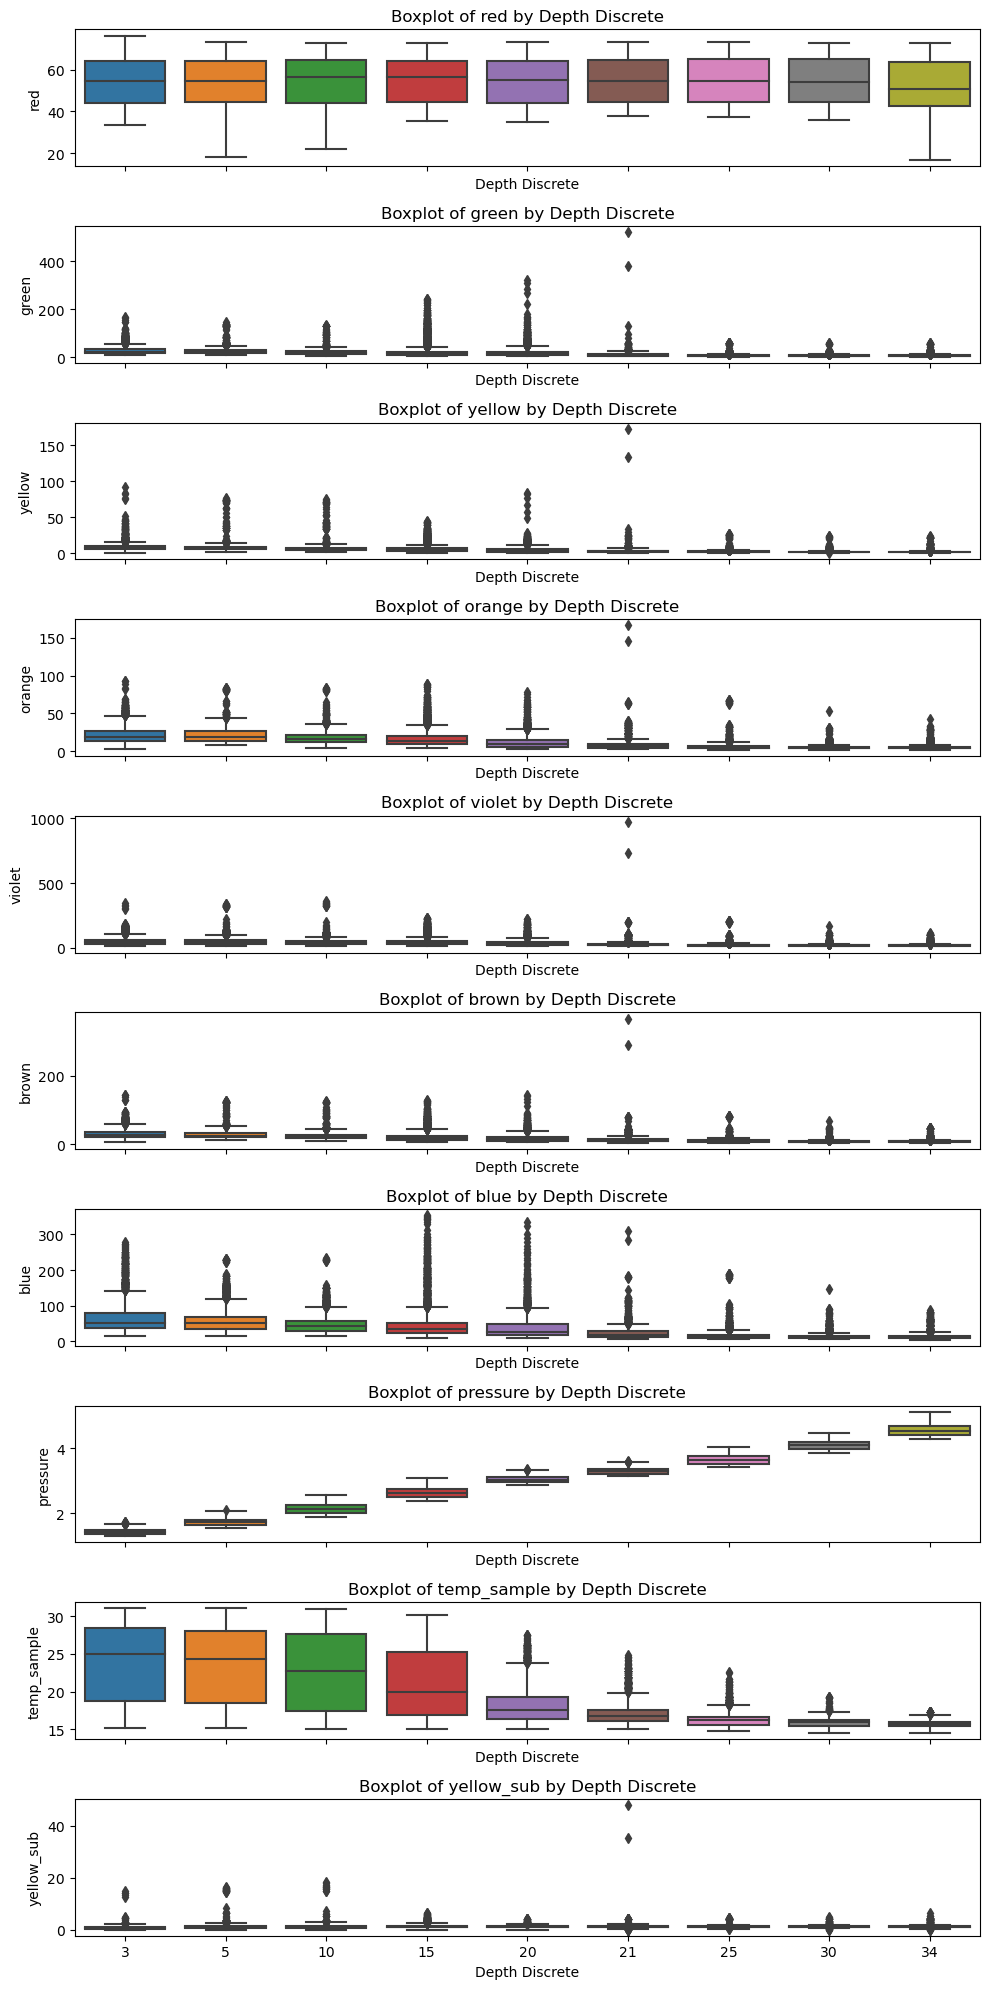

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded and prepared your DataFrame 'fp_df'

# List of signals you want to plot
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sample', 'yellow_sub']

# Create subplots
fig, axes = plt.subplots(nrows=len(signals), ncols=1, figsize=(10, 20), sharex=True)

# Loop through each signal and create a boxplot
for idx, signal in enumerate(signals):
    ax = axes[idx]
    sns.boxplot(x='depth_discrete', y=signal, data=fp_df, ax=ax)
    ax.set_ylabel(signal)
    ax.set_xlabel('Depth Discrete')
    ax.set_title(f'Boxplot of {signal} by Depth Discrete')

plt.tight_layout()
plt.show()

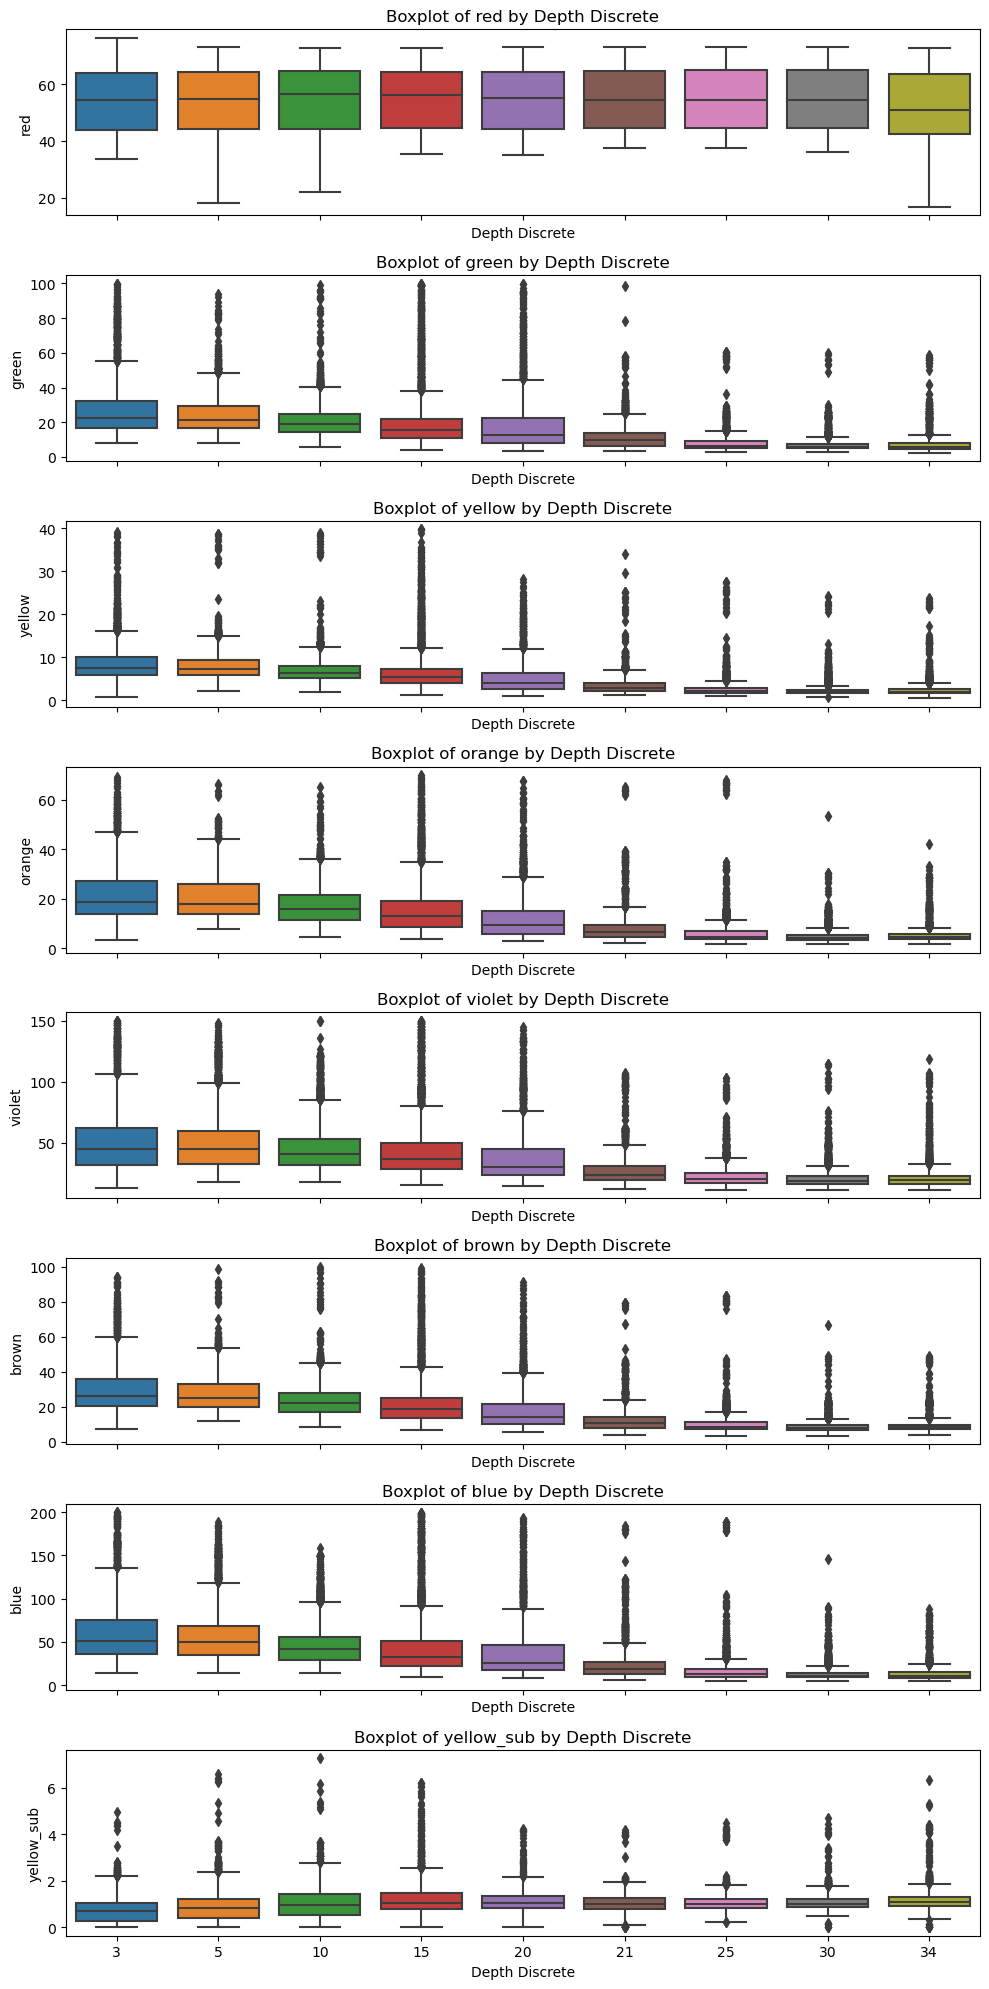

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded and prepared your DataFrame 'fp_df'

# List of signals you want to plot
signals = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'yellow_sub']
# Dictionary to store records to be removed for each signal
records_to_remove = {signal: [] for signal in signals}

# Create subplots
fig, axes = plt.subplots(nrows=len(signals), ncols=1, figsize=(10, 20), sharex=True)

boundaries = {
    'red': {'lower_bound': 0, 'upper_bound': 100},
    'green': {'lower_bound': 0, 'upper_bound': 100},
    'yellow': {'lower_bound': 0, 'upper_bound': 40},
    'orange': {'lower_bound': 0, 'upper_bound': 70},
    'violet': {'lower_bound': 0, 'upper_bound': 150},
    'brown': {'lower_bound': 0, 'upper_bound': 100},
    'blue': {'lower_bound': 0, 'upper_bound': 200},
    'yellow_sub': {'lower_bound': 0, 'upper_bound': 8}

}
# Loop through each signal and create a boxplot
for idx, signal in enumerate(signals):
    ax = axes[idx]
    
    # Calculate IQR
#     q1 = fp_df[signal].quantile(0.25)
#     q3 = fp_df[signal].quantile(0.75)
#     iqr = q3 - q1
    
    # Define upper and lower bounds to filter out outliers
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
    lower_bound = boundaries[signal]['lower_bound']
    upper_bound = boundaries[signal]['upper_bound']
    
    # Filter the DataFrame
    filtered_df = fp_df[(fp_df[signal] >= lower_bound) & (fp_df[signal] <= upper_bound)]
    
    # Identify records to be removed
    outliers = fp_df[(fp_df[signal] < lower_bound) | (fp_df[signal] > upper_bound)]
    
    # Accumulate records to be removed
    records_to_remove[signal].extend(outliers.index.tolist())
    
    # Create the boxplot with the filtered data
    sns.boxplot(x='depth_discrete', y=signal, data=filtered_df, ax=ax)
    ax.set_ylabel(signal)
    ax.set_xlabel('Depth Discrete')
    ax.set_title(f'Boxplot of {signal} by Depth Discrete')

plt.tight_layout()
plt.show()


In [107]:
# Flatten the list of indices to remove
indices_to_remove = set(idx for lst in records_to_remove.values() for idx in lst)

# Remove accumulated records from 'fp_df'
filtered_df = fp_df.drop(index=indices_to_remove)
filtered_df

,depth,red,green,yellow,orange,violet,brown,blue,pressure,temp_sample,yellow_sub,Green Algae,Bluegreen,Diatoms,Cryptophyta,Total conc,week,year,month,depth_discrete
18,1.53,62.74,21.95,6.85,17.53,48.68,24.67,49.79,1.30,19.93,1.20,9.74,0.29,1.63,5.95,17.62,49,2019,12,3
19,1.60,62.66,21.76,7.25,17.09,47.80,24.32,49.24,1.31,19.93,1.16,9.80,0.02,1.16,6.36,17.33,49,2019,12,3
20,1.71,62.43,21.45,7.45,17.27,48.64,24.72,50.14,1.32,19.93,1.16,10.77,0.00,0.63,6.45,17.84,49,2019,12,3
21,1.81,62.61,21.89,7.23,17.14,48.78,24.13,50.87,1.33,19.93,1.13,10.46,0.00,1.53,6.00,17.99,49,2019,12,3
22,1.95,62.65,21.80,7.37,17.84,48.13,24.91,49.41,1.34,19.93,1.16,9.92,0.27,1.16,6.29,17.64,49,2019,12,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45189,36.56,41.90,6.95,2.75,5.40,20.68,9.50,11.33,4.73,15.64,1.14,0.00,0.40,0.63,0.52,1.55,27,2022,7,34
45190,37.02,42.14,6.86,2.45,5.18,20.54,9.27,10.87,4.78,15.62,1.14,0.00,0.39,0.55,0.49,1.43,27,2022,7,34
45191,37.43,41.99,7.12,2.60,5.49,21.09,9.59,11.70,4.82,15.59,1.15,0.00,0.43,0.78,0.43,1.64,27,2022,7,34
45192,37.69,42.01,7.03,2.67,5.22,20.78,9.58,11.20,4.85,15.59,1.15,0.00,0.35,0.47,0.65,1.48,27,2022,7,34


In [108]:
# filtered_df.drop('depth_discrete', axis=1, inplace=True)

## Splitting to test temporarily & Extracting probe's test data

In [109]:
biomass_test = biomass_by_week_year_group[(biomass_by_week_year_group['year'] == 2022) & (biomass_by_week_year_group['month'] >= 3)]
biomass_train = biomass_by_week_year_group[~biomass_by_week_year_group.index.isin(biomass_test.index)]

fp_test = filtered_df[(filtered_df['year'] == 2022) & (filtered_df['month'] >= 3)]
fp_train = filtered_df[~filtered_df.index.isin(fp_test.index)]

merged_train = merge_fp_biomass_df(fp_train, biomass_train, is_train=True) # Merging fully
merged_test = merge_fp_biomass_df(fp_test, biomass_test, is_train=False) # Merging only closest records by depth

In [110]:
merged_train = merged_train.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

fluor_groups_map = {
    2: 'Bluegreen',
    3: 'Diatoms',
    4: 'Green Algae',
    6: 'Cryptophyta'
}

fluor_test_df = merged_test[['group_num', 'month', 'week', 'year', 'Depth', 'sum_biomass_ug_ml', 'Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta']].reset_index(drop=True)
merged_test = merged_test.drop(['Green Algae', 'Bluegreen', 'Diatoms', 'Cryptophyta'], axis=1).reset_index(drop=True)

## Proportionalize the biomass

In [111]:
proportionalize(fluor_test_df, row_wise=True, new_col_prefix='')
proportionalize(fluor_test_df, row_wise=False, new_col_prefix='')
proportionalize(merged_test, row_wise=False, new_col_prefix='proportion_')

In [112]:
prev_depths = {
    3: 0,
    5: 3,
    10: 5,
    15: 10,
    20: 15,
    21: 20,
    25: 21,
    30: 25
}

In [113]:
# Calculate estimated sum_biomass_ug_ml
estimated_biomass = []
current_step = 0  # Initialize the step for the current week-year-month frame
depth_diffs = []

for index, row in merged_train.iterrows():
    # Calculate step for the current week-year-month frame
    next_df = merged_train[(merged_train.week == row.week) & 
                        (merged_train.year == row.year) & 
                        (merged_train.month == row.month) & 
                        (merged_train.group_num == row.group_num) &
                        (merged_train.Depth == prev_depths[row.Depth])]
    if next_df.shape[0] > 0:
        step_numerator = row['sum_biomass_ug_ml'] - next_df.iloc[0]['sum_biomass_ug_ml']
        step_denominator = row['Depth'] - next_df.iloc[0]['Depth']
    else:
        step_numerator = row['sum_biomass_ug_ml']
        step_denominator = row['Depth']

    current_step = step_numerator / step_denominator
        
    depth_diff = row['Depth'] - row['depth']
    depth_diffs.append(depth_diff)
    
    estimated_biomass_value = row['sum_biomass_ug_ml']
    estimated_biomass_value += current_step * depth_diff
    
    estimated_biomass.append(estimated_biomass_value)

merged_train['estimated_sum_biomass_ug_ml'] = estimated_biomass
merged_train['depth_diffs'] = depth_diffs

In [114]:
merged_train.drop(['sum_biomass_ug_ml', 'depth_diffs'], axis=1, inplace=True)
merged_train.rename(columns={'estimated_sum_biomass_ug_ml': 'sum_biomass_ug_ml'}, inplace=True)

# Plot

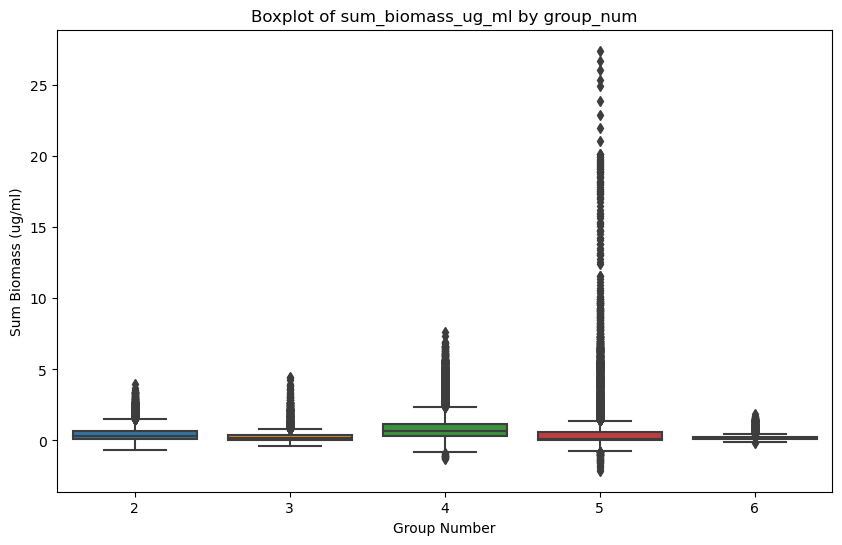

In [115]:
boxplot(merged_train)

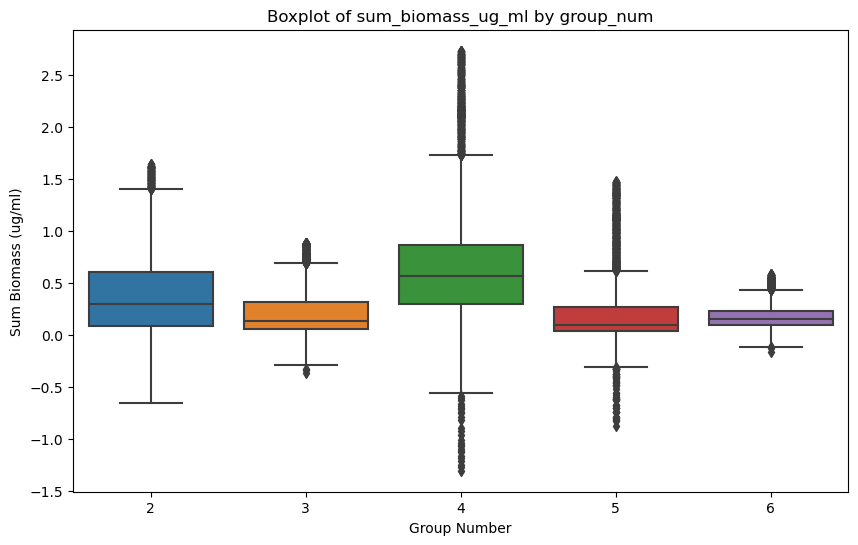

In [116]:
filtered_df = remove_outliers_IQR(merged_train, q1=0.05, q3=0.75)
boxplot(filtered_df)

In [117]:
merged_train = filtered_df

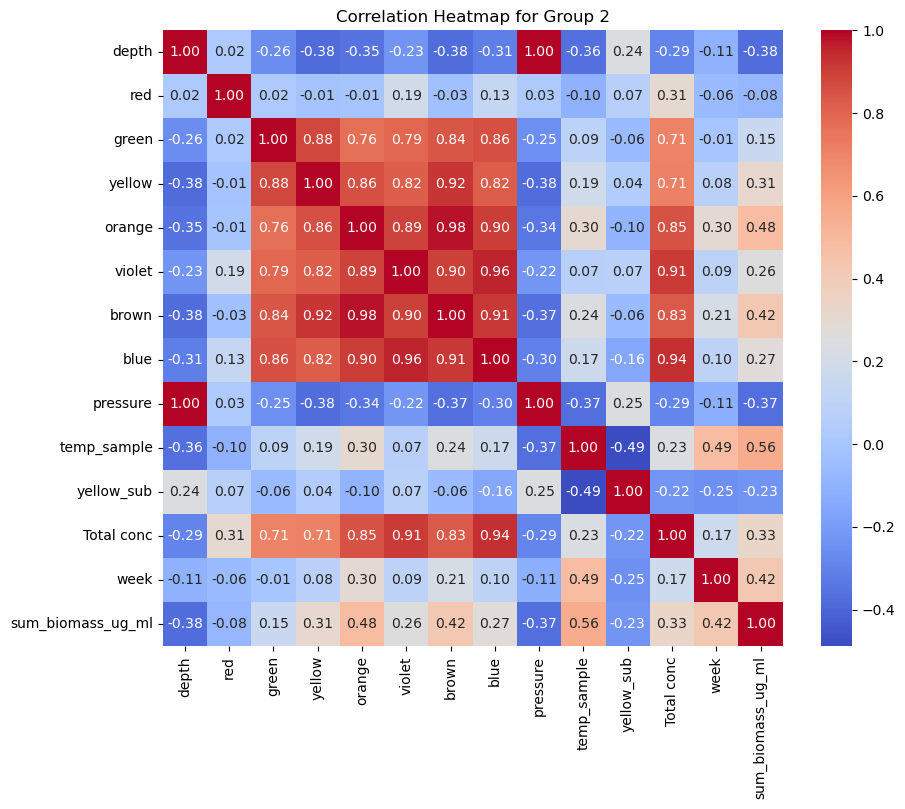

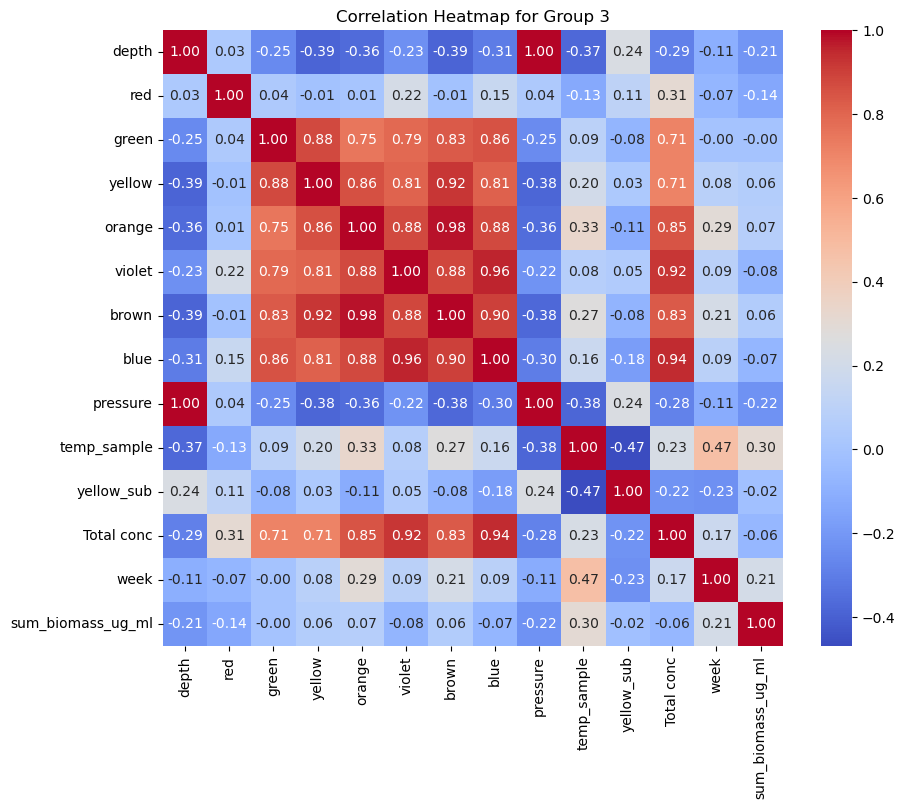

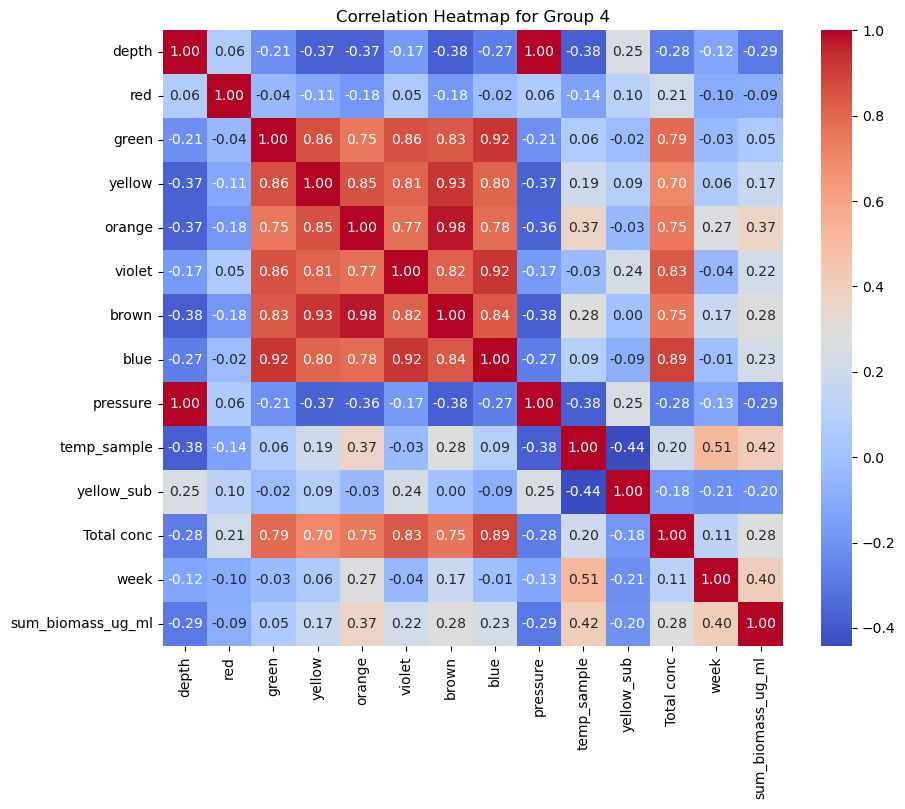

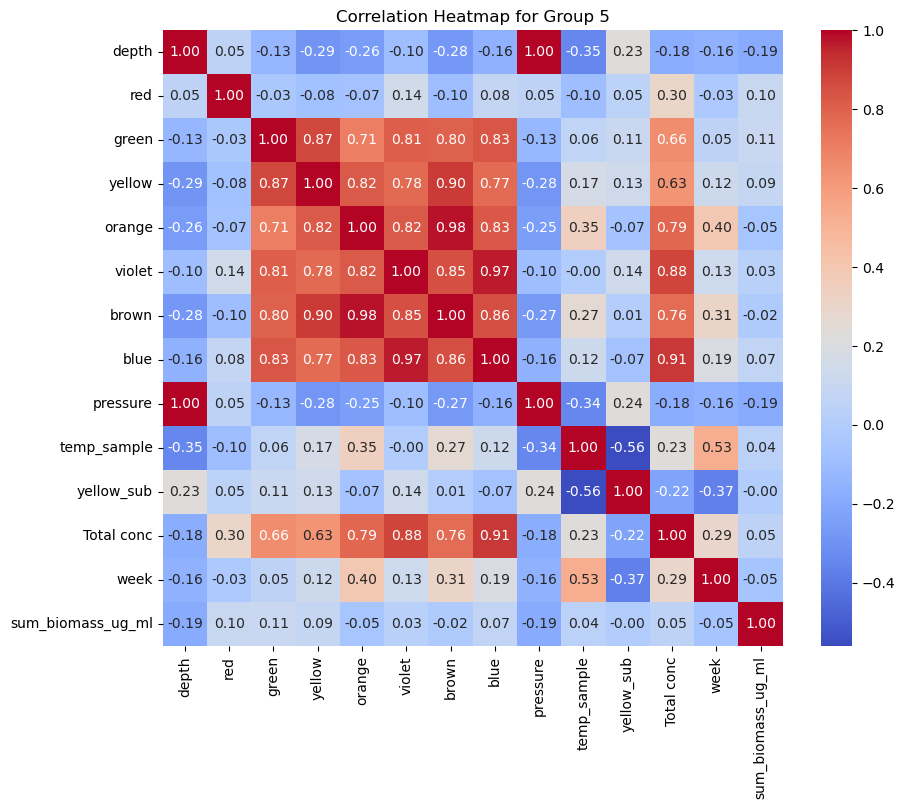

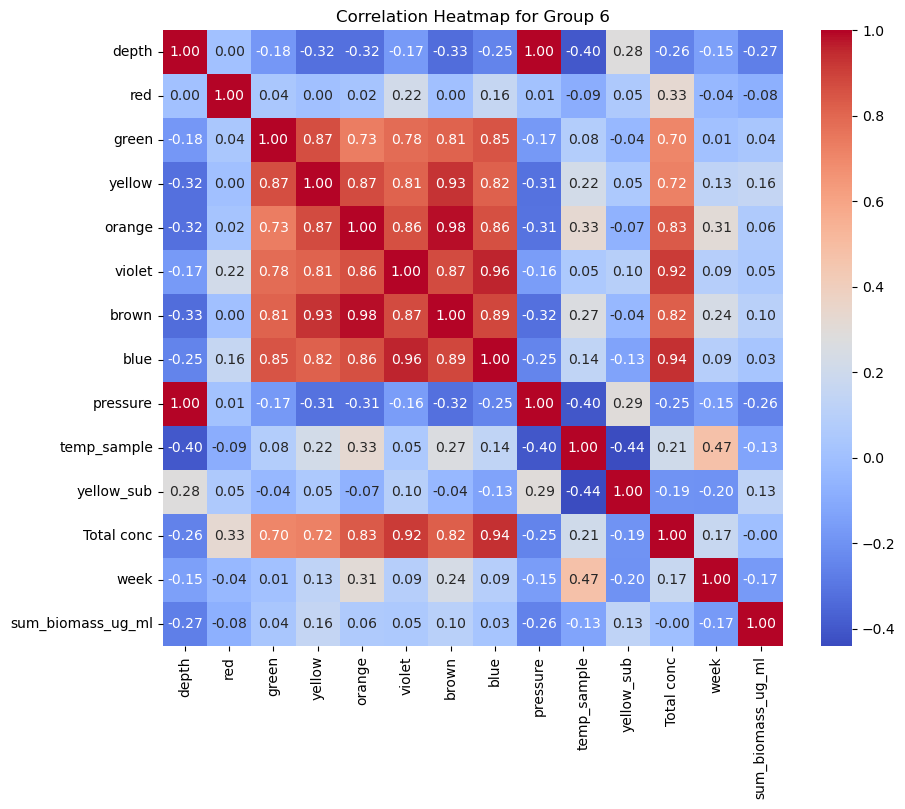

In [118]:
correlation_per_group(merged_train)

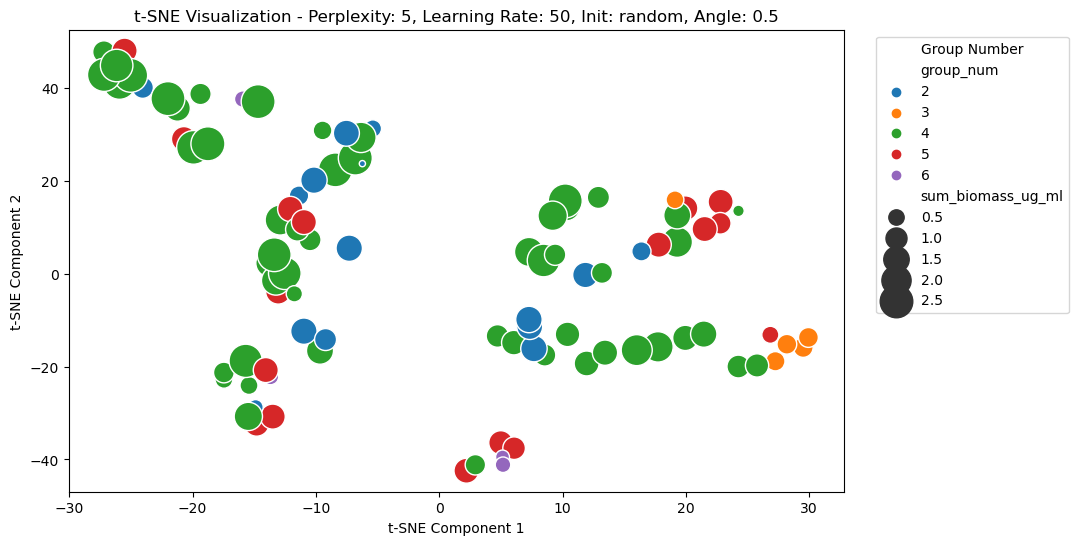

In [119]:
plot_tsne(merged_train)

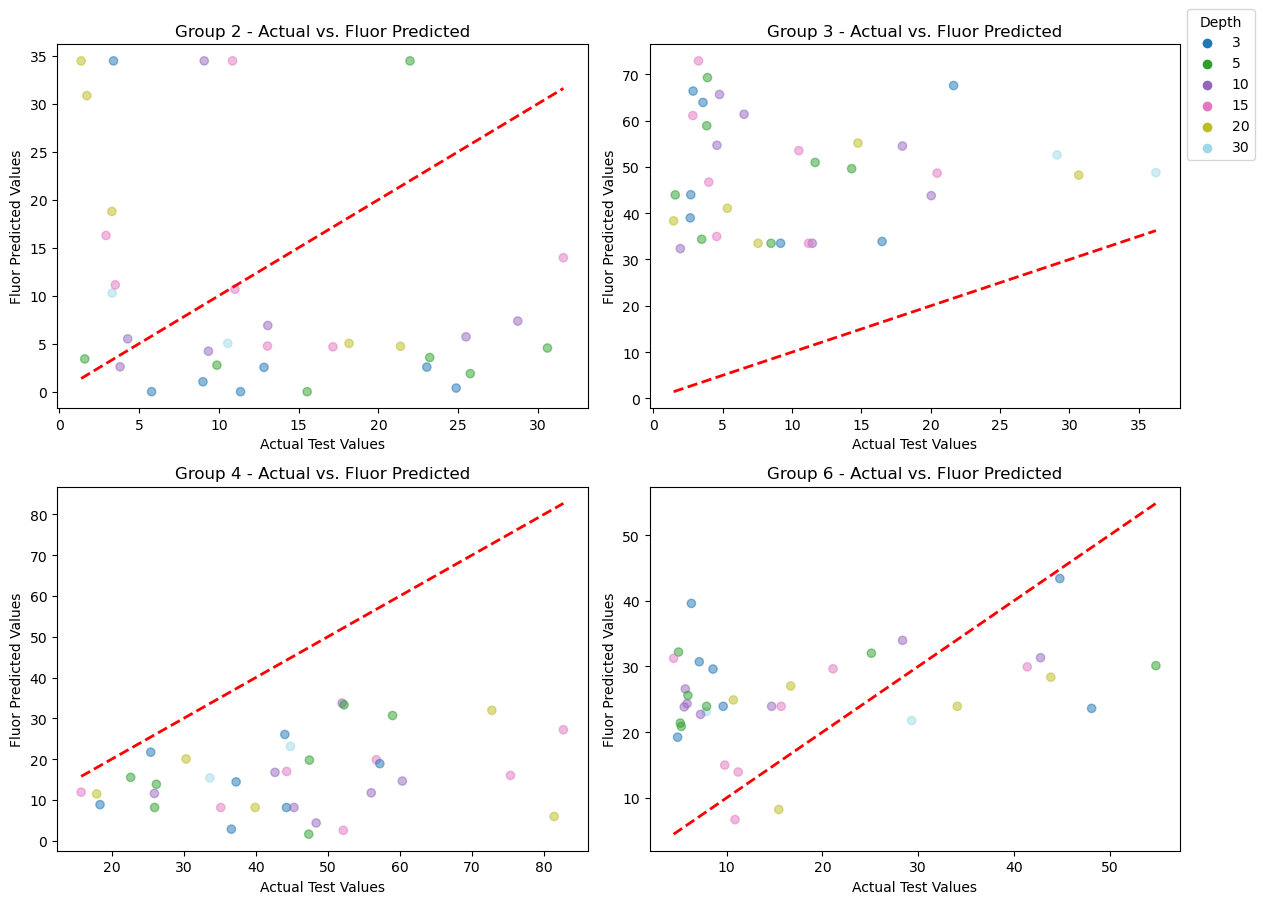

In [120]:
plot_fluorprobe_prediction(fluor_test_df, fluor_groups_map)

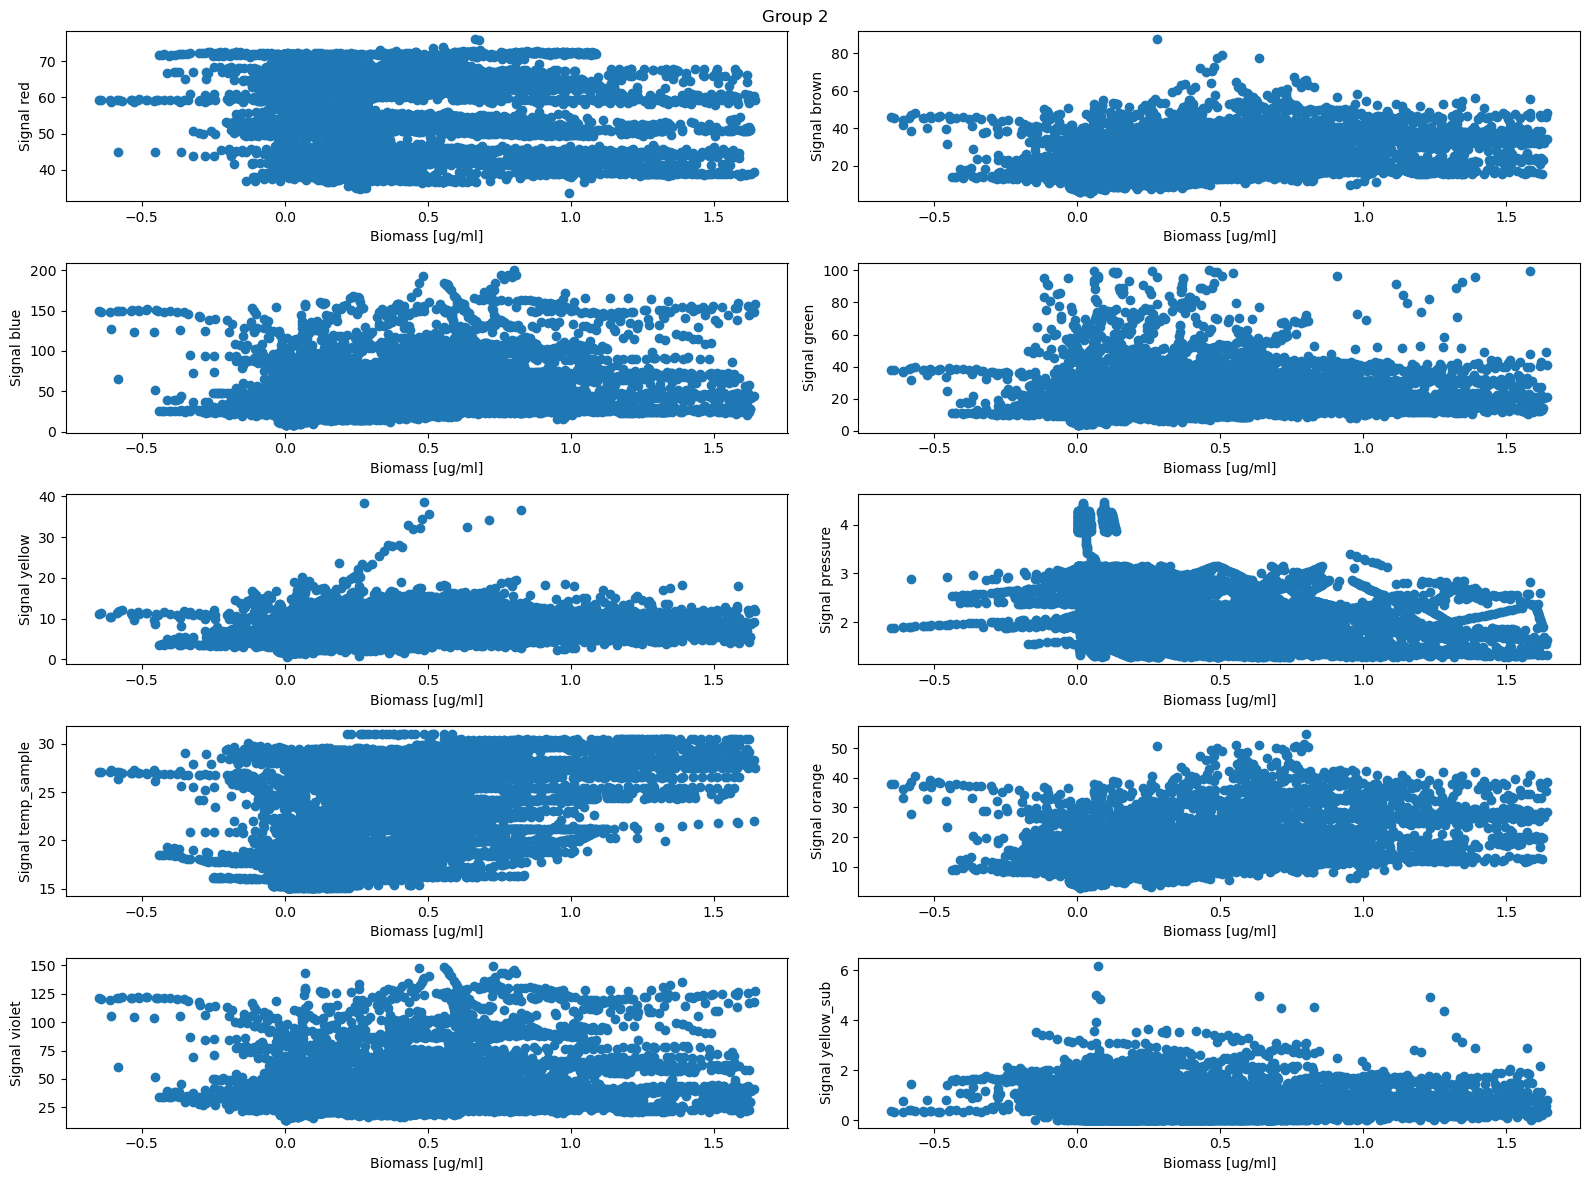

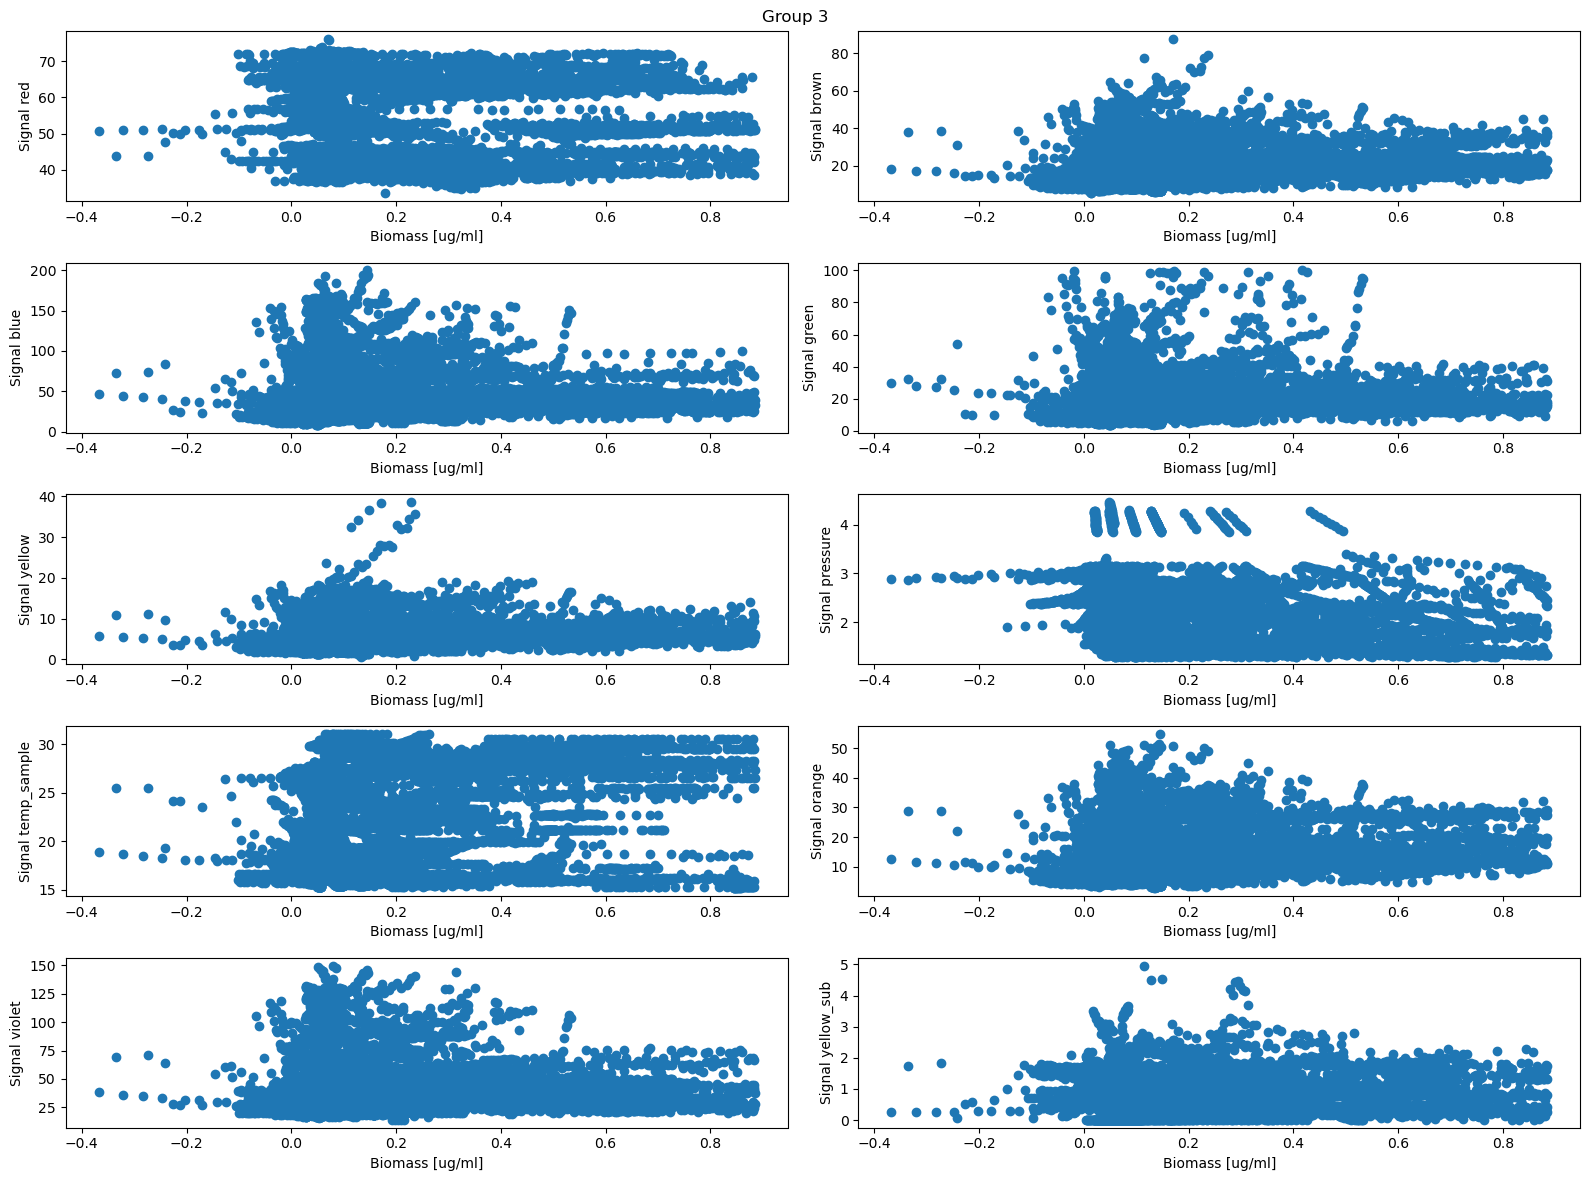

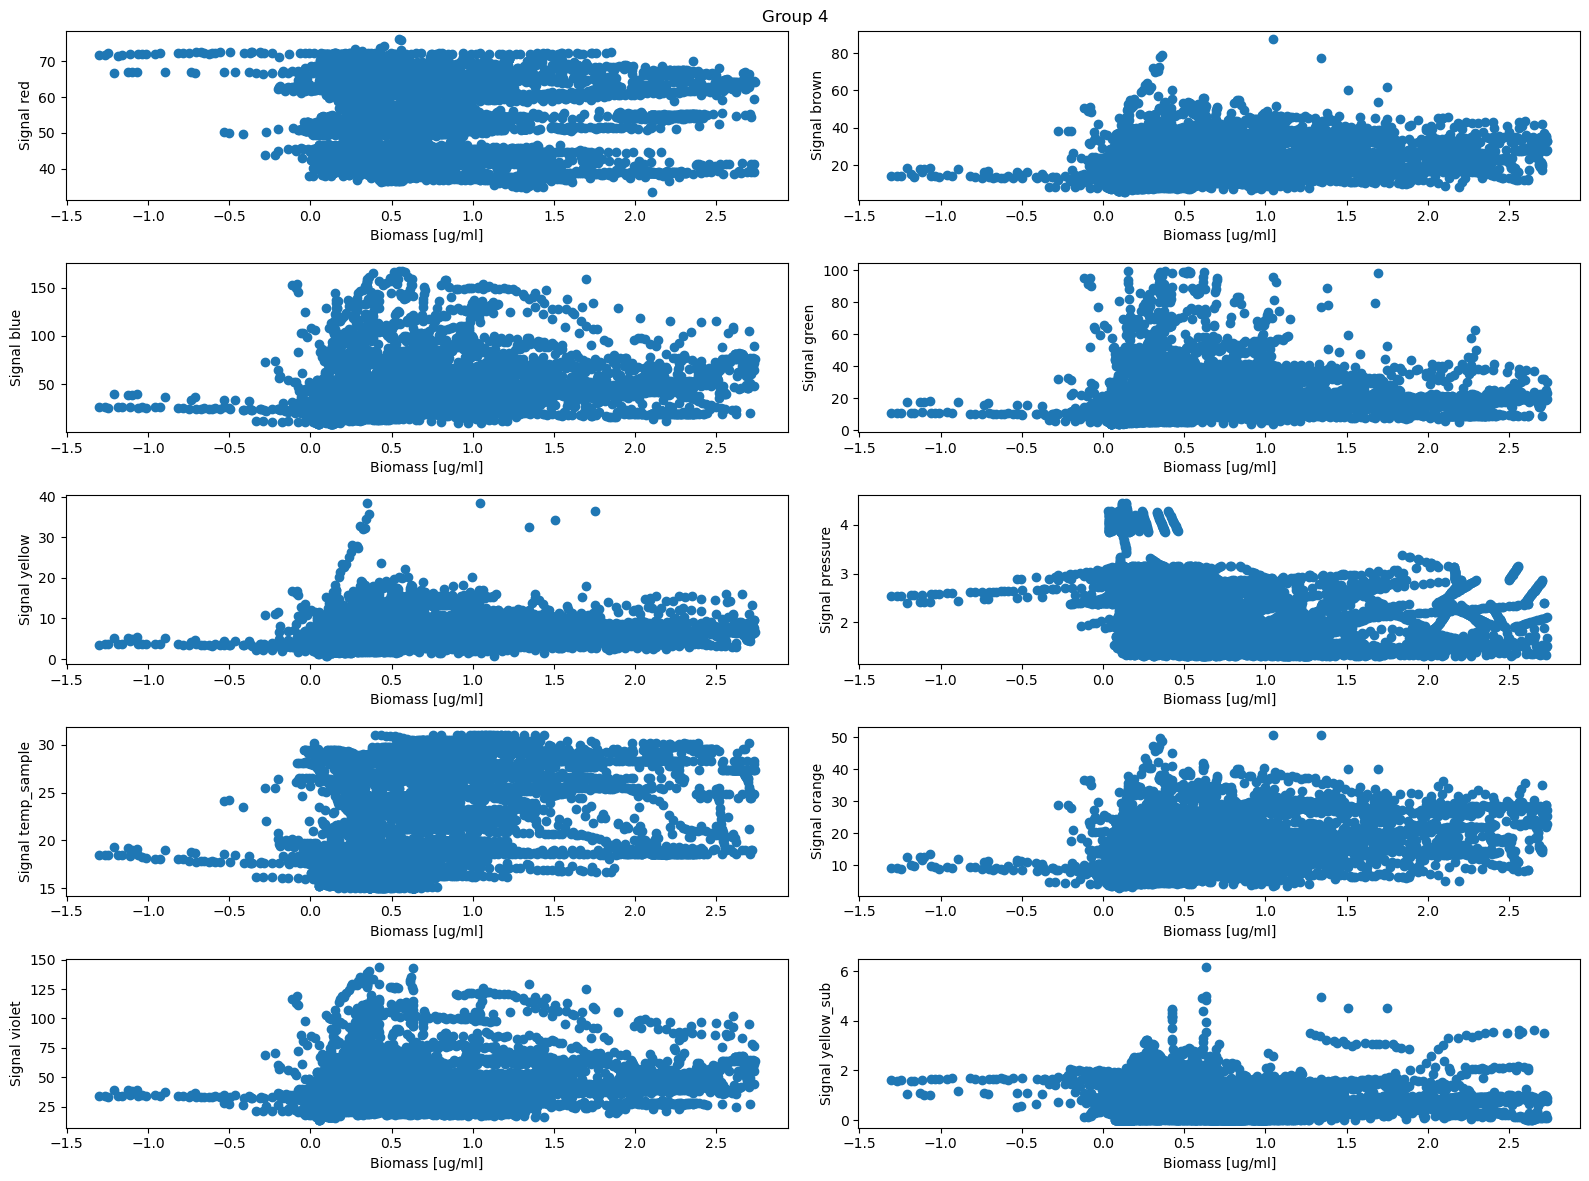

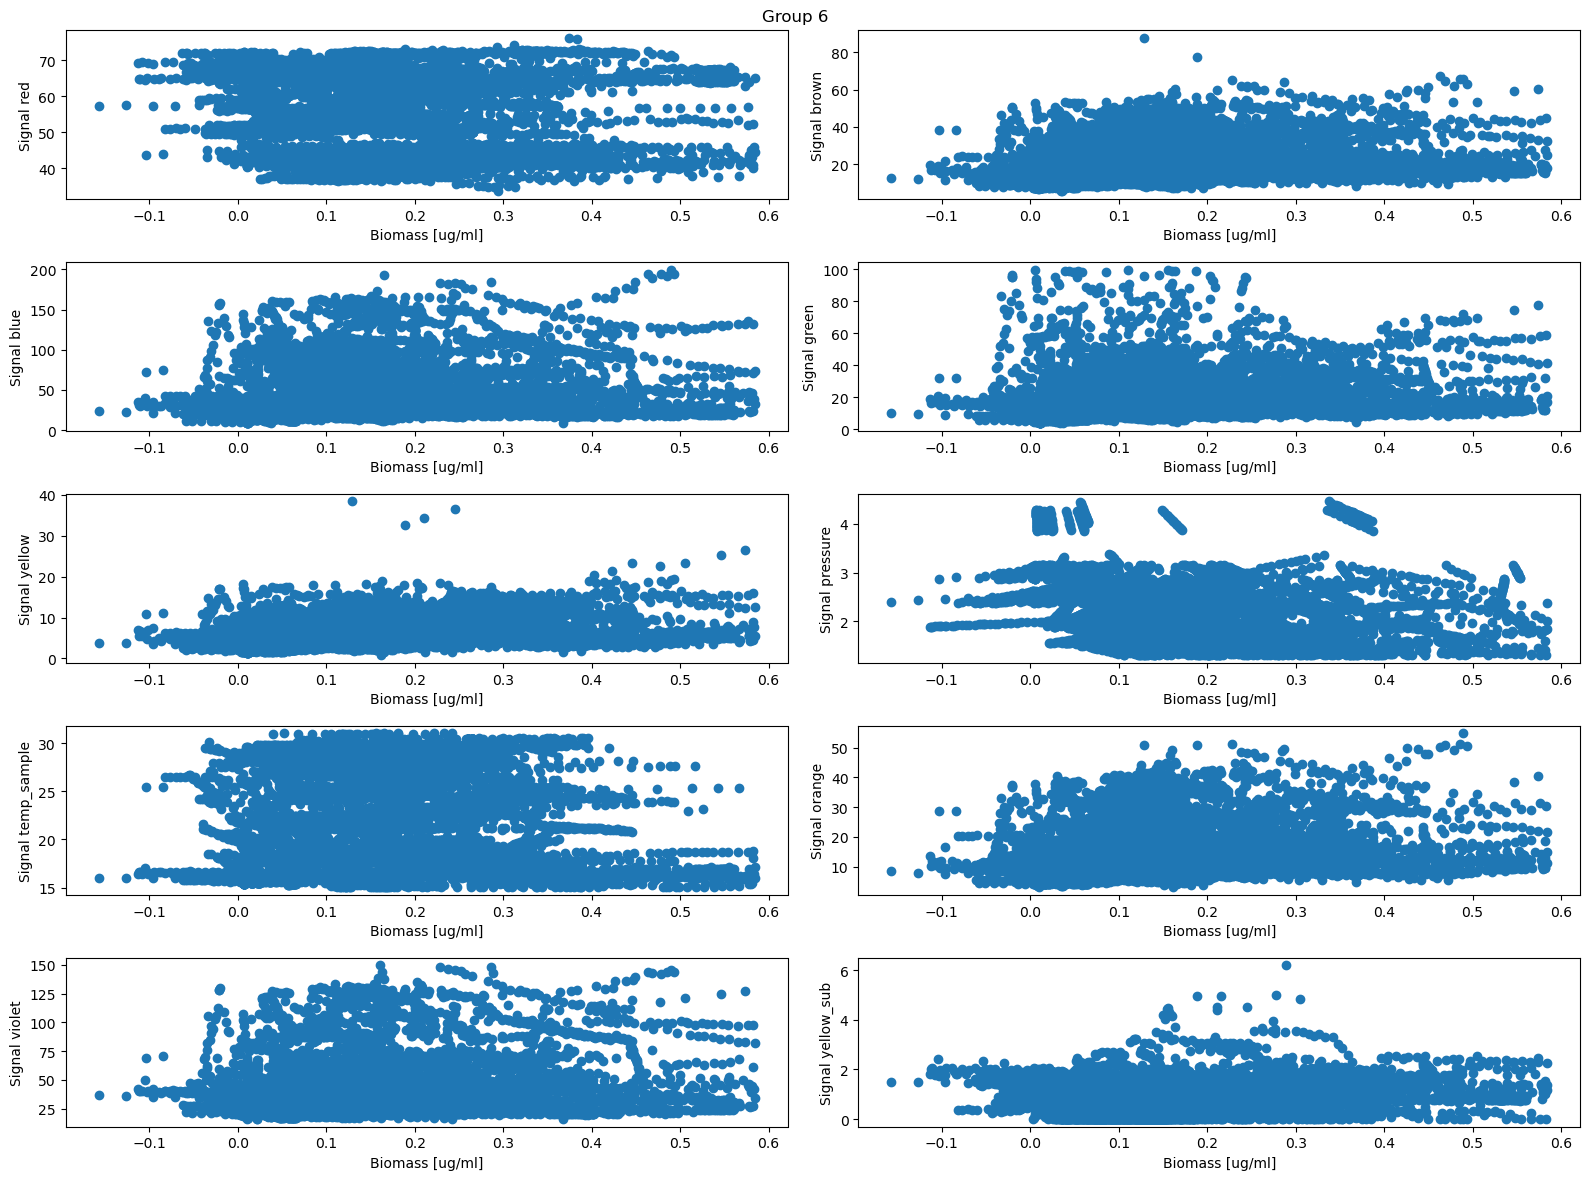

In [121]:
plot_corr_per_feature_per_group(merged_train, fluor_groups_map)

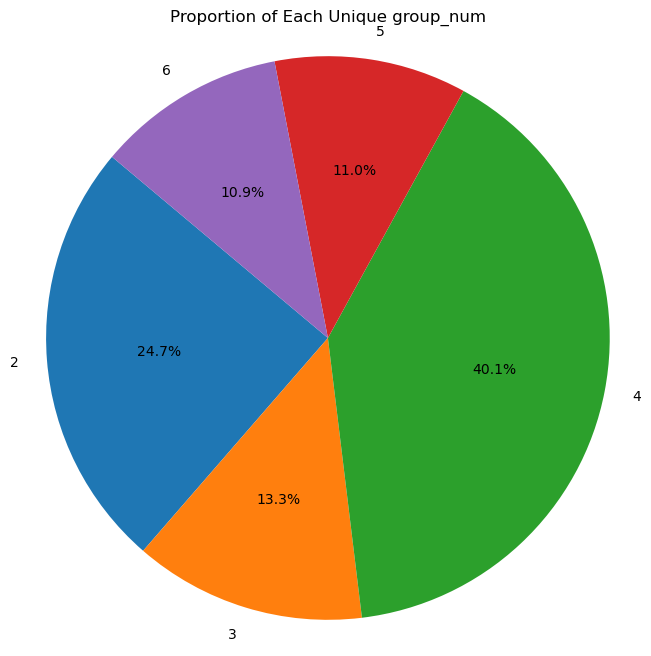

In [122]:
groups_pie_chart(merged_train, by_biomass=True)

In [123]:
merged_train = merged_train.drop(['year', 'Depth', 'depth', 'week'], axis=1)
orig_merged_test = merged_test.copy()
merged_test = merged_test.drop(['year', 'Depth', 'week', 'depth_discrete'], axis=1)
fluor_test_df = fluor_test_df.drop('Depth', axis=1)

# Training models and evaluating

## Grid Search per model

In [124]:
pickled_params = 'best_grid_params.pkl'
do_search = not os.path.exists(pickled_params)

In [125]:
def two_scorer(mse=False):
    score = mean_squared_error if mse else r2_score
    return make_scorer(score, greater_is_better=mse==False)

In [126]:
if do_search:
#     param_grid_per_model = {'xgb': {
#         "model__n_estimators": [100, 300, 500], # Number of boosting rounds
#         "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
#         "model__max_depth": [3, 5, 7, 11], # Maximum depth of a tree,
#         'model__min_child_weight': [1, 5, 7],  # Minimum sum of instance weight needed in a child
#         "model__subsample": [0.2, 0.5, 1.0], # Fraction of samples used for fitting trees
#         "model__colsample_bytree": [0.2, 0.8, 1.0] # Fraction of features used for fitting trees
#     },
#     'svr':  {
#         "model__C": [0.1, 1, 10, 100], # Regularization parameter
#         "model__kernel": ["poly", "rbf"],
#         "model__degree": [1, 2, 3], # Degree of the polynomial kernel (for "poly" kernel)
#         "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
#         "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
#     },
#     'elf': {
#         "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
#         "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
#         "model__fit_intercept": [True, False], # Whether to calculate the intercept for the model
#     }}
    param_grid_per_model = {'xgb': {
        "model__n_estimators": [100, 300, 500], # Number of boosting rounds
        "model__max_depth": [2, 3, 5], # Maximum depth of a tree,
        "model__learning_rate": [0.01, 0.1, 0.2], # Step size shrinkage
        "model__alpha": [0.01, 0.1, 1, 10], # L1 regularization term
        "model__lambda": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    },
    'svr':  {
        "model__C": [0.001, 0.1, 1, 10, 100], # Regularization parameter
        "model__epsilon": [0.01, 0.1, 0.2], # Epsilon in the epsilon-SVR loss function
        "model__tol": [1e-4, 1e-3, 1e-2] # Tolerance for stopping criterion
    },
    'elf': {
        "model__alpha": [0.01, 0.1, 1, 10], # Regularization parameter
        "model__l1_ratio": [0.2, 0.5, 0.8], # Mixing parameter between L1 and L2 regularization
    }}
    
    best_group_params_per_model = {}
    for model_name, param_grid in param_grid_per_model.items():
        best_group_params_per_model[model_name] = grid_search_cv(model_name, merged_train, param_grid=param_grid,
                                                                scoring_method=two_scorer(mse=False))
    
    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model, f)
    
    best_group_params_per_model_fixed = {}
    for model_name, kwargs_per_group in best_group_params_per_model.items():
        best_group_params_per_model_fixed[model_name] = {}
        for group_num in kwargs_per_group.keys():
            best_group_params_per_model_fixed[model_name][group_num] = {}
            kwargs = kwargs_per_group[group_num]
            for param, val in kwargs.items():
                fixed_param = param.split('model__')[1]
                best_group_params_per_model_fixed[model_name][group_num][fixed_param] = val


    with open(pickled_params, 'wb') as f:
        pickle.dump(best_group_params_per_model_fixed, f)

else:
    with open(pickled_params, 'rb') as f:
        best_group_params_per_model_fixed = pickle.load(f)

In [127]:
regularized_kwargs = {}
param_per_model = {'xgb': {
    "max_depth": 5, # Maximum depth of a tree,
    "alpha": 10, # L1 regularization term
    "lambda": 0.5, # Mixing parameter between L1 and L2 regularization
},
'svr':  {
    "C": 10000, # Regularization parameter
    "tol": 1e-3 # Tolerance for stopping criterion
},
'elf': {
    "alpha": 10, # Regularization parameter
    "l1_ratio": 0.0, # Mixing parameter between L1 and L2 regularization
}}
for model_name in best_group_params_per_model_fixed.keys():
    regularized_kwargs[model_name] = {}
    for group_num in best_group_params_per_model_fixed[model_name].keys():
        regularized_kwargs[model_name][group_num] = param_per_model[model_name]

## Retraining After Grid Search

In [128]:
regression_models = {}
for model_name, best_group_params_fixed in best_group_params_per_model_fixed.items():
    regression_models[model_name], _ = train('xgb', merged_train, group_kwargs=regularized_kwargs, test_size=0.0, biomass_factor=100)

## Linear Regression

In [129]:
regression_models['lr'], _ = train('lr', merged_train, test_size=0.0, biomass_factor=100)

## Comparing All Models

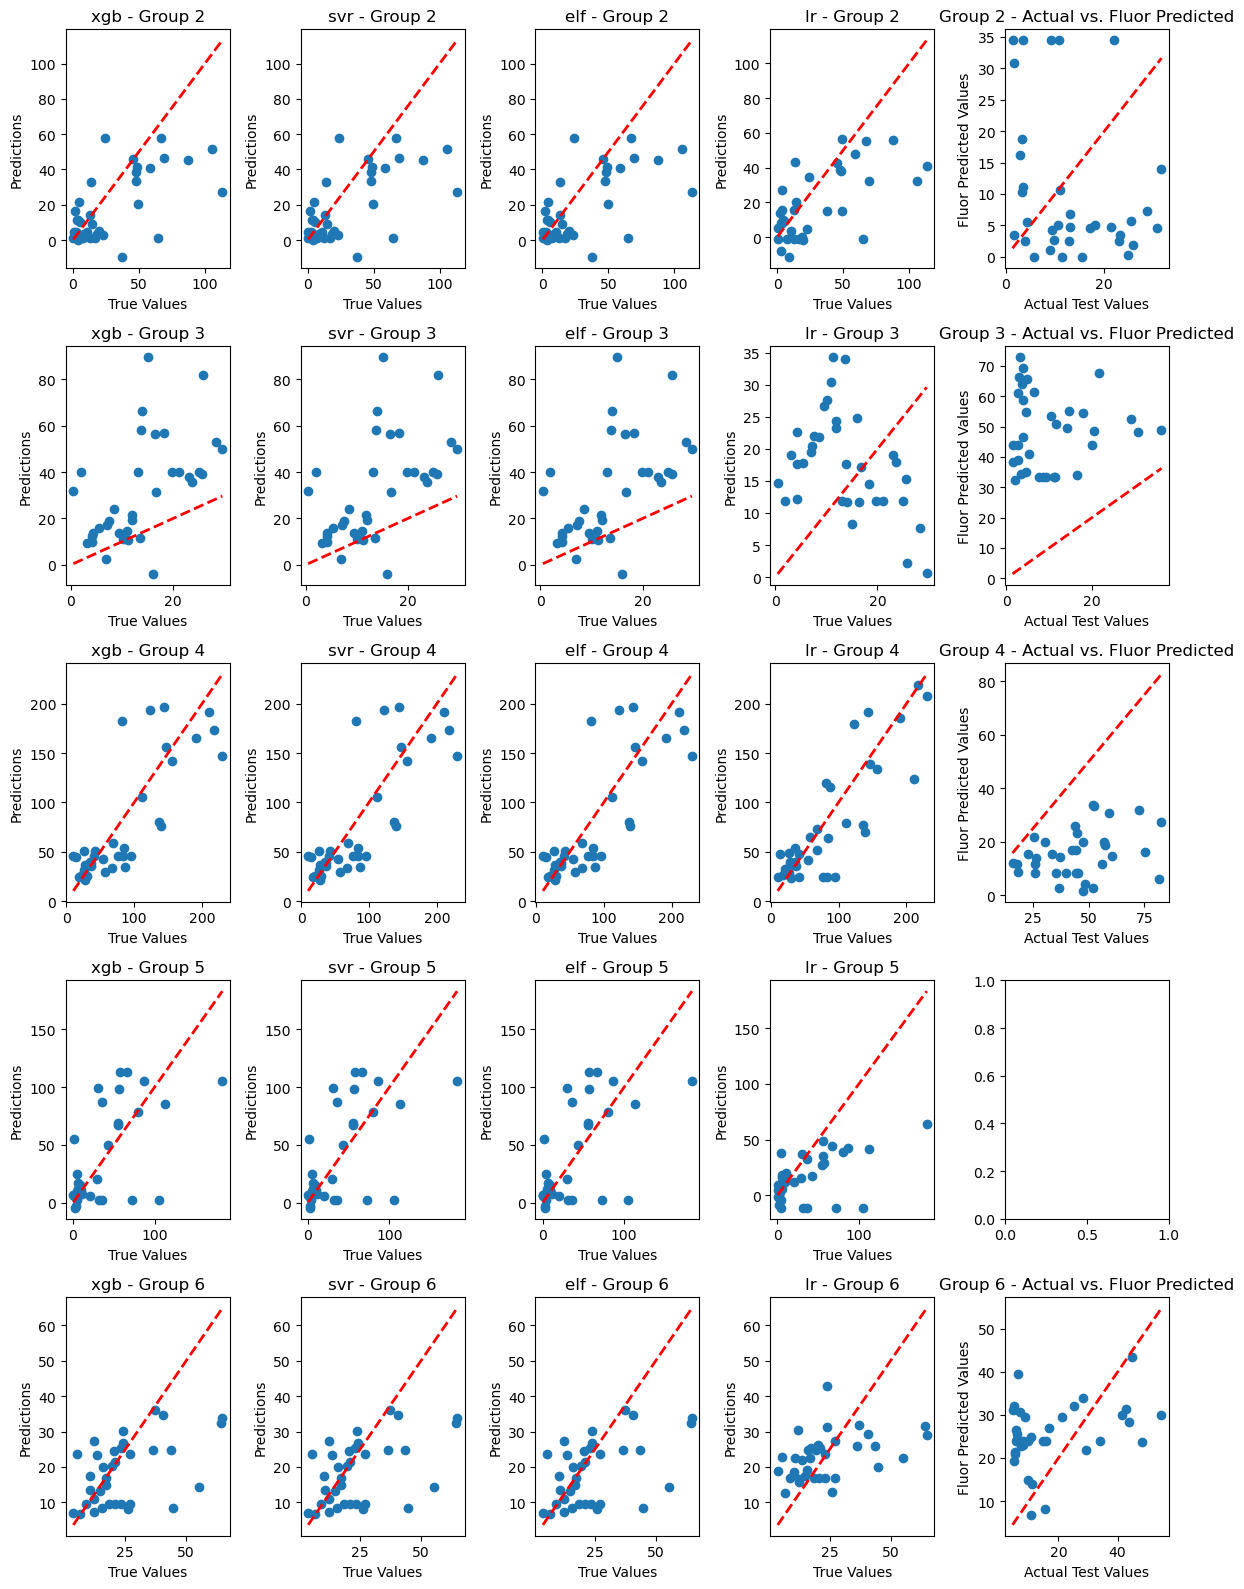

In [131]:
comparing_df = compare_all_models(regression_models, merged_test, fluor_test_df, fluor_groups_map, biomass_factor=100)

In [132]:
comparing_df[comparing_df['Group'] != 3].groupby('Model')[['RMSE', 'R-squared']].mean()

,RMSE,R-squared
Model,,
FP,22.229472,-1.809568
elf,28.455854,0.313370
lr,28.485563,0.300499
svr,28.455854,0.313370
xgb,28.455854,0.313370


## Linear Regression

In [ ]:
regression_models['lr'], _ = train('lr', merged_df, test_size=0.0, biomass_factor=100)

In [37]:
# eval_test(regression_models_lr, merged_df_test, biomass_factor=100)

In [38]:
# residual_analysis(merged_df_test, regression_models_lr, biomass_factor=100)

## XGBoost

In [54]:
# keep_cols = merged_df.columns

In [55]:
# from sklearn.feature_selection import SelectKBest, f_regression
# selkbest= SelectKBest(f_regression, k=5)
# X_new = selkbest.fit_transform(merged_df.drop('sum_biomass_ug_ml', axis=1), merged_df['sum_biomass_ug_ml'])

In [56]:
# selkbest.get_feature_names_out()

In [57]:
# keep_cols = ['orange', 'brown', 'blue', 'Total conc', 'group_num', 'sum_biomass_ug_ml']

In [60]:
# regression_models_xgboost, preds_real_y_xgboost = train('xgb', merged_df, test_size=0.0, biomass_factor=100)

In [ ]:
# eval_test(regression_models_xgboost, merged_df_test, biomass_factor=100)

In [ ]:
# compare_to_fluor(regression_models_xgboost, merged_df_test, fluor_groups_map, fluor_test_df, biomass_factor=100)

In [ ]:
# residual_analysis(merged_df_test, regression_models_xgboost, biomass_factor=100)

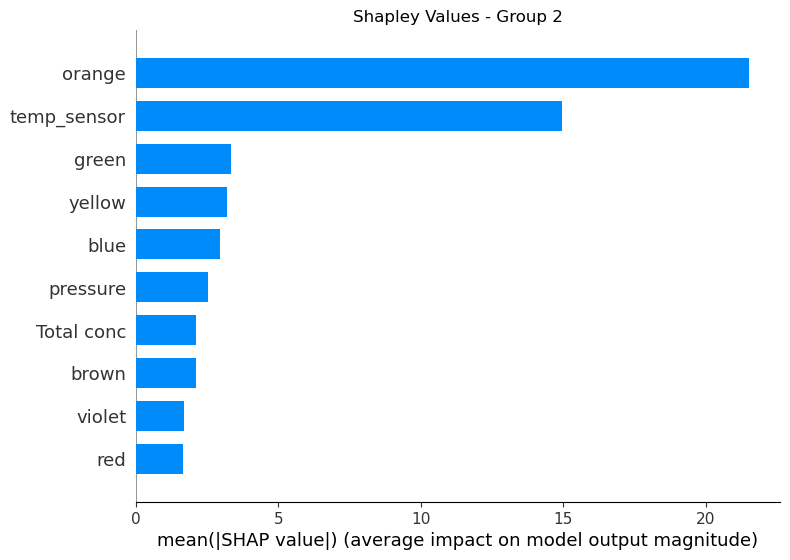

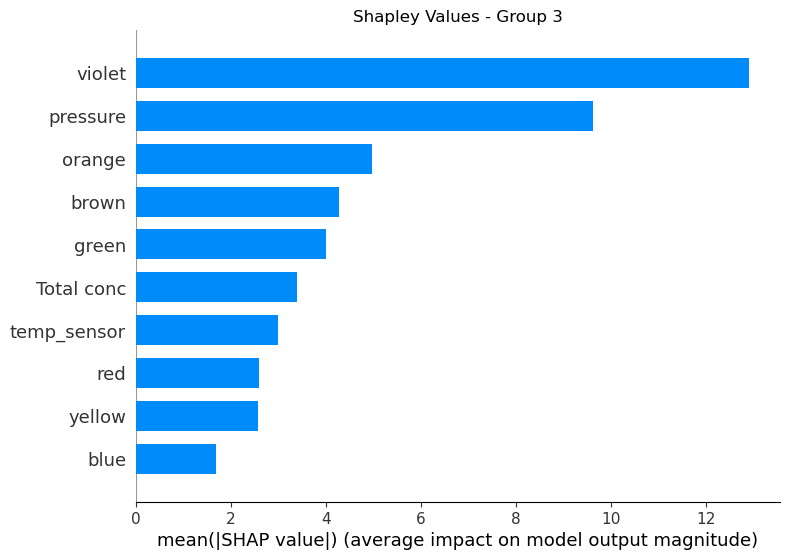

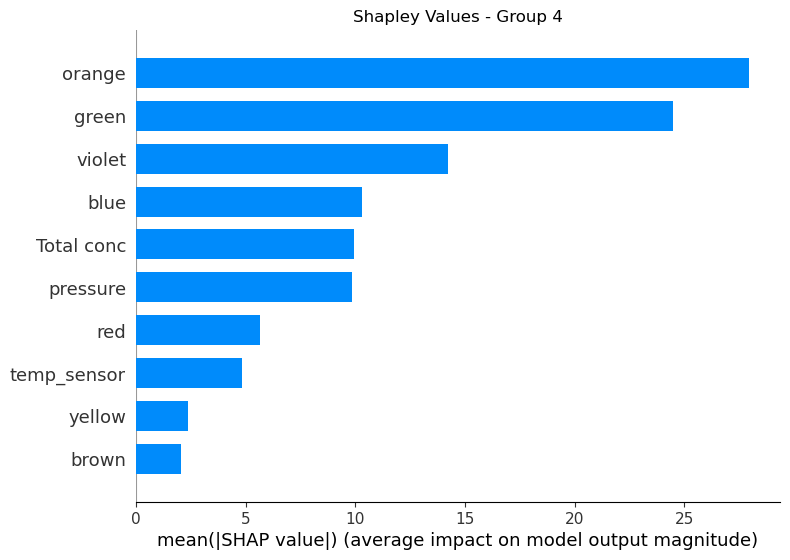

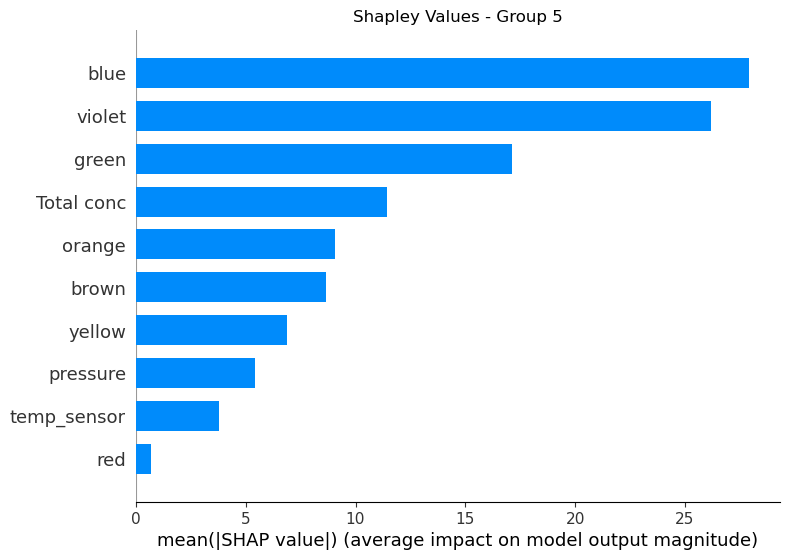

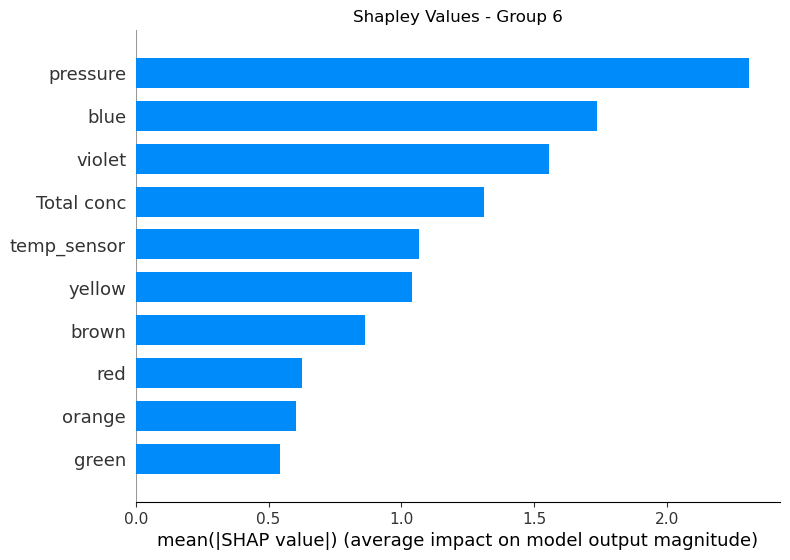

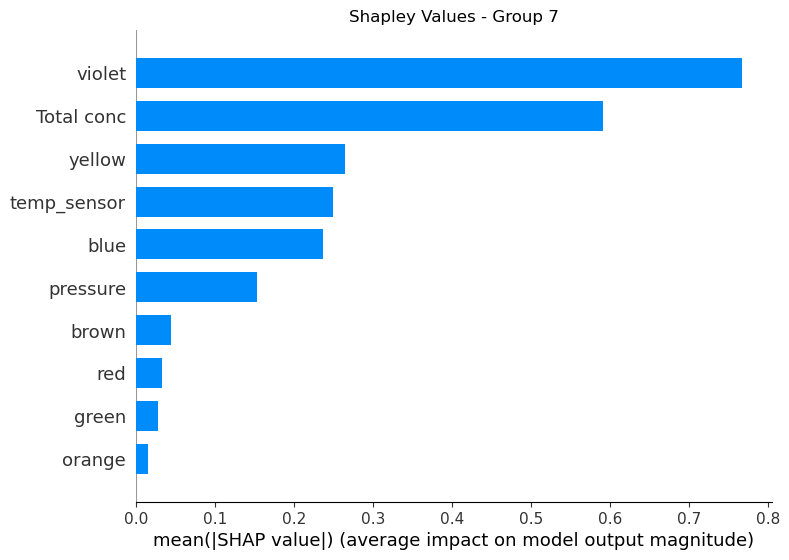

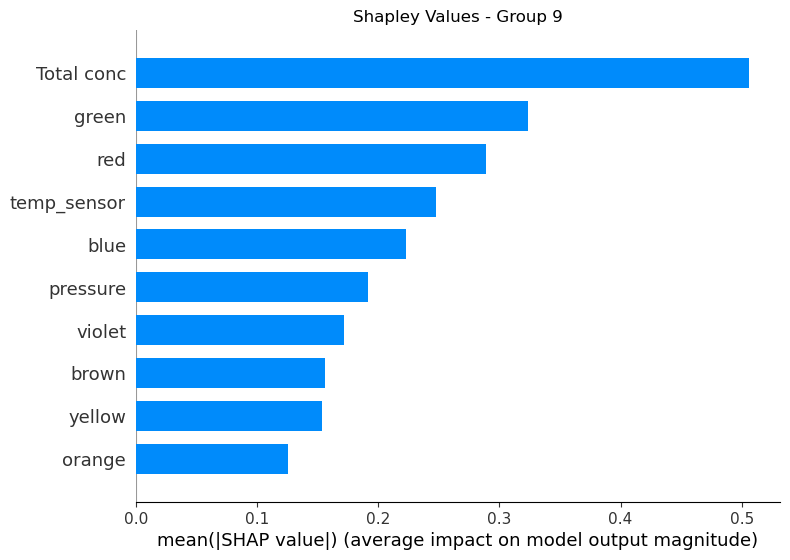

In [74]:
shap_values_list = plot_shap_values(merged_df_test, regression_models_xgboost, merged_df_test)

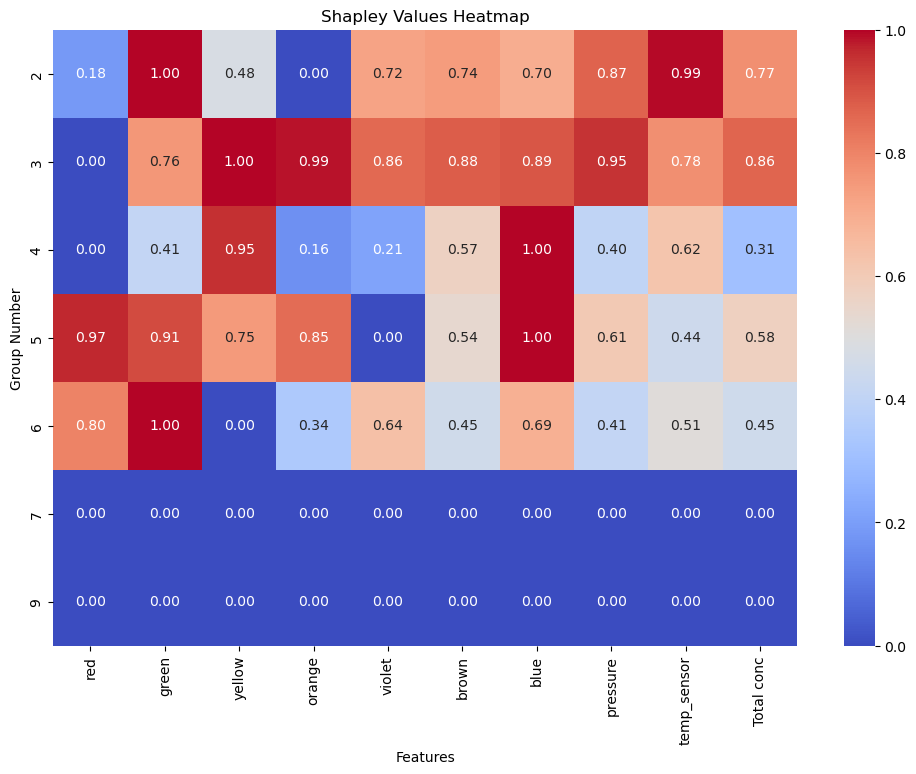

In [83]:
features_list = merged_df_test.drop(['group_num', 'sum_biomass_ug_ml'], axis=1).columns.tolist()

# Create a DataFrame from the Shapley values
shap_df = pd.DataFrame({k: np.average(v.values, axis=0) for k, v in shap_values_list.items()}, index=features_list)

scaler = MinMaxScaler()
scaled_shap_df = pd.DataFrame(scaler.fit_transform(shap_df), columns=shap_df.columns, index=shap_df.index)
    
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(scaled_shap_df.transpose(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Shapley Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Group Number")
plt.show()


## SVR

In [101]:
# regression_models_svr, preds_real_y_xgboost = train('svr', merged_df, test_size=0.0, biomass_factor=100, group_kwargs=group_kwargs)

In [ ]:
# eval_test(regression_models_svr, merged_df_test, biomass_factor=100)

In [ ]:
# compare_to_fluor(regression_models_svr, merged_df_test, fluor_groups_map, fluor_test_df, biomass_factor=100)

## ElasticNet Regression

In [ ]:
# regression_models_elf, preds_real_y_xgboost = train('elf', merged_df, test_size=0.0, biomass_factor=100)

In [ ]:
# eval_test(regression_models_elf, merged_df_test, biomass_factor=100)

In [ ]:
# compare_to_fluor(regression_models_elf, merged_df_test, fluor_groups_map, fluor_test_df, biomass_factor=100)